# **HW2 - Series temporales: BMW vs Volkswagen**
# Álvaro Payo Bastante

## **1. Importar librerías y datos**

### **1.1. Librerías**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import sktime
from sktime.utils.plotting import plot_correlations

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm

from scipy import stats

from arch.univariate import ARX
from arch.univariate import ARCH, GARCH 
from arch.univariate import StudentsT

In [5]:
# Importamos la libreria de gráficos Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

### **1.2. Datos BMW**

In [6]:
bmw = yf.Ticker("BMW.DE")

In [7]:
bmw_hist = bmw.history(period="max")
bmw_hist.index = bmw_hist.index.date
bmw_hist.index = pd.to_datetime(bmw_hist.index)
bmw_hist = bmw_hist.rename_axis('Fecha')

### **1.3. Datos Volkswagen**

In [8]:
volks = yf.Ticker("VOW.DE")

In [9]:
volks_hist = volks.history(period="max")
volks_hist.index = volks_hist.index.date
volks_hist.index = pd.to_datetime(volks_hist.index)
volks_hist = volks_hist.rename_axis('Fecha')

## **2. Estima un modelo VAR mensual entre los dos activos. (Muestra: 2009/01 a 2020/10)**

### **2.1. Muestra y división en train y test**

In [10]:
#BMW

#Paso de las fechas a mensuales mediante un resample
bmw_hist_month = bmw_hist.resample("m").last()

In [11]:
#Me quedo con el periodo que me indica el enunciado
muestra_bmw = bmw_hist_month.loc['2009-01':'2021-10']

In [12]:
#Volkswagen

#Paso de las fechas a mensuales mediante un resample
volks_hist_month = volks_hist.resample("m").last()

In [13]:
#Me quedo con el periodo que me indica el enunciado
muestra_volks = volks_hist_month.loc['2009-01':'2021-10']

In [14]:
#muestra de los dos activos
bmw_volks_muestra = pd.DataFrame()

bmw_volks_muestra['bmw_close'] = muestra_bmw['Close']
bmw_volks_muestra['volks_close'] = muestra_volks['Close']

bmw_volks_muestra.tail()

,bmw_close,volks_close
Fecha,,
2021-06-30,83.012917,261.730164
2021-07-31,77.965775,269.380524
2021-08-31,74.703262,272.459167
2021-09-30,76.924751,257.835663
2021-10-31,81.088867,270.150177


In [15]:
#train desde 2009-01 hasta 2020-10
#test desde 2020-11 hasta 2021-10

data_train = bmw_volks_muestra['2009-01-31':'2020-10-31']
data_test = bmw_volks_muestra['2020-11-30':'2021-10-31']

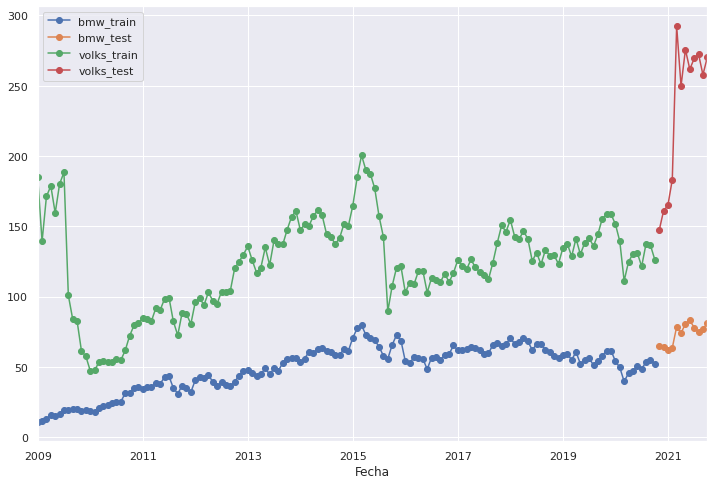

In [16]:
#Plot data (train y test de bmw y volkswagen en el mismo gráfico)
data_train['bmw_close'].plot(legend=True,label='bmw_train',marker='o')
data_test['bmw_close'].plot(legend=True,label='bmw_test',figsize=(12,8),marker='o');

data_train['volks_close'].plot(legend=True,label='volks_train',marker='o')
data_test['volks_close'].plot(legend=True,label='volks_test',figsize=(12,8),marker='o');

Tras importar las librerías necesarias y cargar los datos con la librería yfinance, resampleo los **datos a mensuales** y **selecciono el periodo** que me indica el enunciado. 

Una vez he hecho esto para BMW y para Volkswagen, creo un **DataFrame que consiste en las columnas de 'Close' de ambas marcas**, ya que este es el precio final y debo tener ambos juntos. El índice del DataFrame consiste en la fecha.

Para poder estimar el modelo VAR, **divido los datos en train y test**. Train consiste en el periodo desde enero de 2009 hasta octubre de 2020, y test en el periodo desde noviembre de 2020 hasta octubre de 2021.

Por último, hago un **gráfico en el que muestro el train y el test de las dos marcas a la vez**. En este gráfico podemos ver que los precios de Volkswagen están constantemente por encima de los de BMW, lo que nos permite ver los precios de ambas marcas con claridad, ya que no se solapan ni se cruzan en ningún momento.

### **2.2. Transformación estacionaria**

In [17]:
#Diferencia respecto al precio anterior en ambas columnas para train
diff_data_train = data_train.diff().dropna()
diff_data_train

,bmw_close,volks_close
Fecha,,
2009-02-28,0.677486,-45.505157
2009-03-31,1.212344,32.064636
2009-04-30,2.650515,7.370178
2009-05-31,-0.322975,-19.222214
2009-06-30,0.869278,20.648575
...,...,...
2020-06-30,3.745232,0.823624
2020-07-31,-1.881493,-9.700455
2020-08-31,4.836857,16.014908


<AxesSubplot:xlabel='Fecha'>

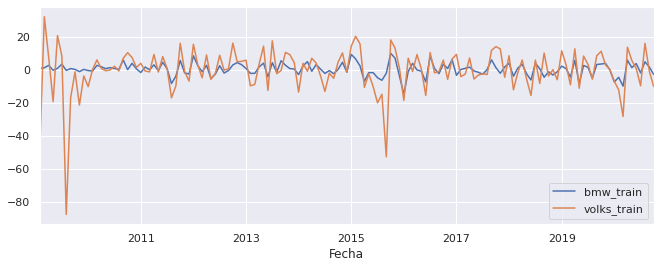

In [18]:
#Gráfico de las variaciones entre los precios de BMW y Volkswagen
diff_data_train['bmw_close'].plot(legend=True,label='bmw_train')

diff_data_train['volks_close'].plot(legend=True,label='volks_train')

Tras crear un nuevo DataFrame con las diferencias de precio respecto a la fila anterior para ambas columnas, decido volver a plotear ambas columnas en el mismo gráfico. 

En este caso, aunque si que se crucen ambas marcas, considero que se ve mejor la diferencia y que se distinguen bien con los colores. 

Se puede ver como **hay mas variaciones en los precios de Volkswagen que en los de BMW**, ya que la línea naranja se mueve más que la azul. 

**Destaca la gran bajada de precio de Volkswagen al principio del gráfico, y otra bajada considerable entre 2015 y 2017**. El precio de BMW no experimenta variaciones tan notables, ya que su precio es mas lineal. 

Por último, se puede apreciar como **ambos precios son bastante parecidos al final de train** (octubre de 2020), **estando el de Volkswagen ligeramente por debajo del de BMW.**



### **2.3. Autocorrelations (AC) & Parcial Autocorrelations (PC)**

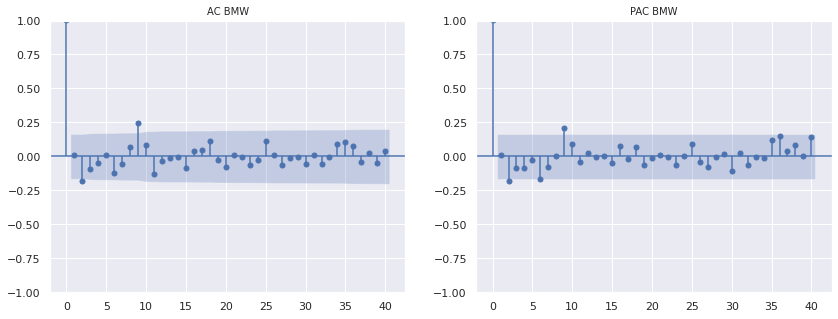

In [19]:
#Gráficos de autocorrelaciones para BMW
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_acf(diff_data_train['bmw_close'].dropna(), lags = 40, ax=ax1)
ax1.set_title('AC BMW', fontsize=10)

plot_pacf(diff_data_train['bmw_close'].dropna(), lags = 40, method='ywm', ax=ax2)
ax2.set_title('PAC BMW', fontsize=10)

plt.show()
plt.close()

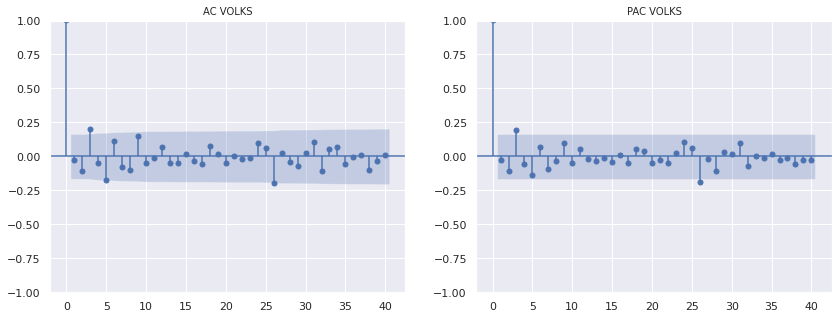

In [20]:
#Gráficos de autocorrelaciones para Volkswagen
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2)

plot_acf(diff_data_train['volks_close'].dropna(), lags = 40, ax=ax1)
ax1.set_title('AC VOLKS', fontsize=10)

plot_pacf(diff_data_train['volks_close'].dropna(), lags = 40, method='ywm', ax=ax2)
ax2.set_title('PAC VOLKS', fontsize=10)

plt.show()
plt.close()

Antes de estimar el modelo VAR, ploteo las AutoCorrelations (AC) y las Partial AutoCorrelations (PAC) de ambas marcas.

Para estos gráficos se establece por defecto un **intervalo de confianza del 95%**. Todo lo que esté dentro de este intervalo representa un valor que no tiene una correlación significativa con el valor más reciente del precio.

Por lo que, para ambas marcas, **sus valores pasados no tienen un poder predictivo significativo sobre el precio actual (ruido blanco).**



### **2.4. Aplicación del modelo VAR**

In [21]:
#definir el VAR
model = VAR(diff_data_train)

#maximo lag a seleccionar
model.select_order(24) #al ser mensual

In [22]:
#estimar los modelos y seleccionar
results = model.fit(maxlags = 24, ic = 'aic')

In [23]:
#lag con menor AIC
results.k_ar

2

In [24]:
#El modelo estimado
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Nov, 2022
Time:                     11:03:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.69313
Nobs:                     139.000    HQIC:                   7.56781
Log likelihood:          -904.465    FPE:                    1775.93
AIC:                      7.48202    Det(Omega_mle):         1654.74
--------------------------------------------------------------------
Results for equation bmw_close
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.287416         0.330788            0.869           0.385
L1.bmw_close           0.069048         0.102597            0.673           0.501
L1.volks_close        -0.035054         0.030303    

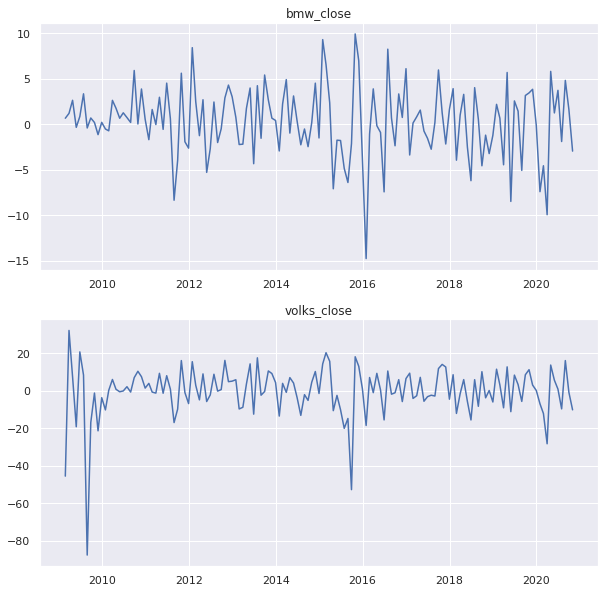

In [25]:
#gráfico de los datos
results.plot();

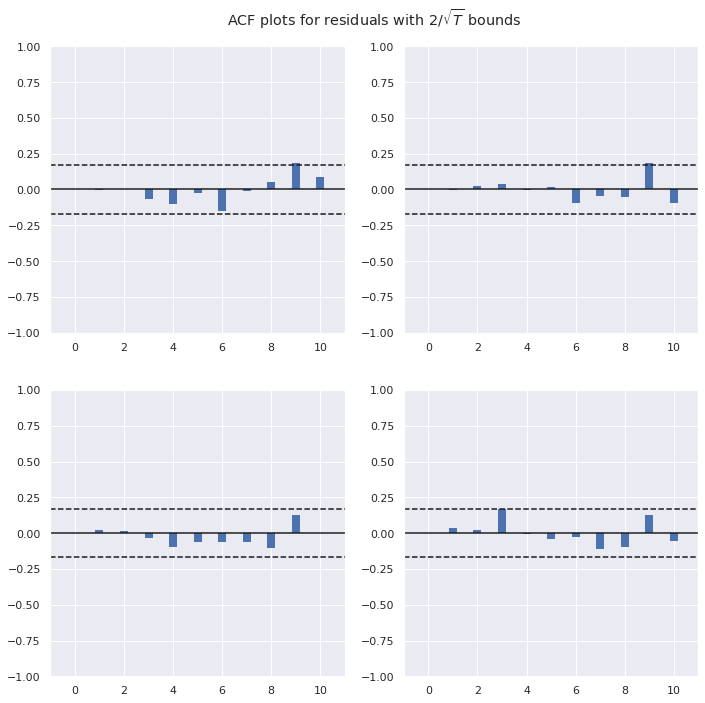

In [26]:
#correlaciones de los residuos
results.plot_acorr();

El modelo VAR se utiliza para estimar **relaciones de retroalimentación**, donde la variable dependiente está relacionada con las variables predictoras y viceversa. 

Se relacionan las observaciones actuales de una variable con observaciones pasadas de sí misma y observaciones pasadas de otras variables en el sistema.

Respecto a nuestro modelo, se puede concluir que **las variables no están relacionadas entre sí**, ya que los coeficientes son bajos o negativos, y los p-values están todos por encima del 15%.

Además, **la matriz de correlación de los residuos indica una correlación de casi el 60%**, un porcentaje que no es demasiado alto.

Respecto a **los gráficos de autocorrelación de los residuos**, estos **son muy pequeños** (todos se encuentran entre +- 0.25), indicando que **hemos recogido la mayor parte de dependencia temporal para ambas.**

## **3. Predicción para octubre de 2021 de los dos activos**

In [27]:
lag_order = results.k_ar
lag_order

2

In [28]:
diff_data_train.values[-lag_order:]

array([[  1.63299179,  -0.91516113],
       [ -2.93761444, -10.21199036]])

In [29]:
#Hacemos 12 predicciones (desde noviembre de 2020 hasta octubre de 2021)
results.forecast(diff_data_train.values[-lag_order:], 12)

array([[ 0.26600295, -0.42754879],
       [ 0.9764904 ,  0.27558134],
       [ 0.32436119, -0.21418726],
       [ 0.18828525, -0.24954932],
       [ 0.27501991, -0.35520981],
       [ 0.30260722, -0.36760323],
       [ 0.2971959 , -0.32849803],
       [ 0.29238139, -0.32139308],
       [ 0.2913564 , -0.32881846],
       [ 0.29194079, -0.33105266],
       [ 0.29239838, -0.33016883],
       [ 0.29239017, -0.32965544]])

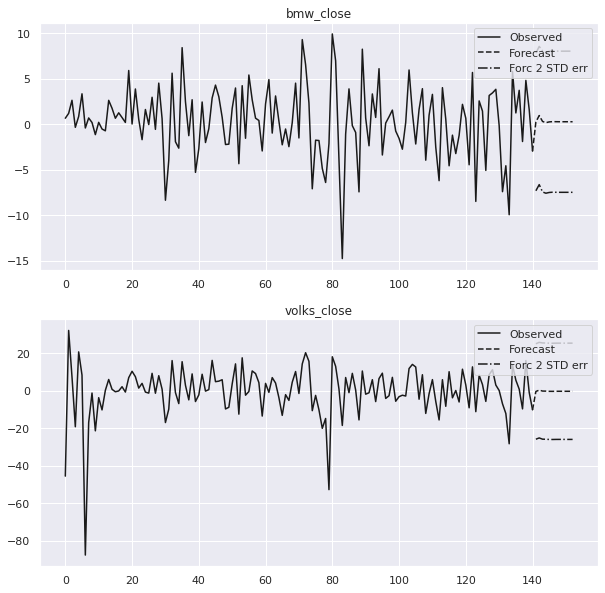

In [30]:
results.plot_forecast(12);

In [31]:
f_data = data_train.values[-1:] + results.forecast(diff_data_train.values[-lag_order:], 12)
f_data

array([[ 52.34426147, 125.89888248],
       [ 53.05474891, 126.60201261],
       [ 52.4026197 , 126.11224402],
       [ 52.26654376, 126.07688196],
       [ 52.35327843, 125.97122146],
       [ 52.38086574, 125.95882805],
       [ 52.37545442, 125.99793324],
       [ 52.3706399 , 126.00503819],
       [ 52.36961491, 125.99761282],
       [ 52.3701993 , 125.99537861],
       [ 52.37065689, 125.99626245],
       [ 52.37064869, 125.99677583]])

In [32]:
data_fore = pd.DataFrame(f_data)
data_fore.index = data_test.index
data_fore.rename(columns={0: 'f_bmw', 1: 'f_volks'}, inplace=True)
data_fore 

,f_bmw,f_volks
Fecha,,
2020-11-30,52.344261,125.898882
2020-12-31,53.054749,126.602013
2021-01-31,52.402620,126.112244
2021-02-28,52.266544,126.076882
2021-03-31,52.353278,125.971221
2021-04-30,52.380866,125.958828
2021-05-31,52.375454,125.997933
2021-06-30,52.370640,126.005038
2021-07-31,52.369615,125.997613


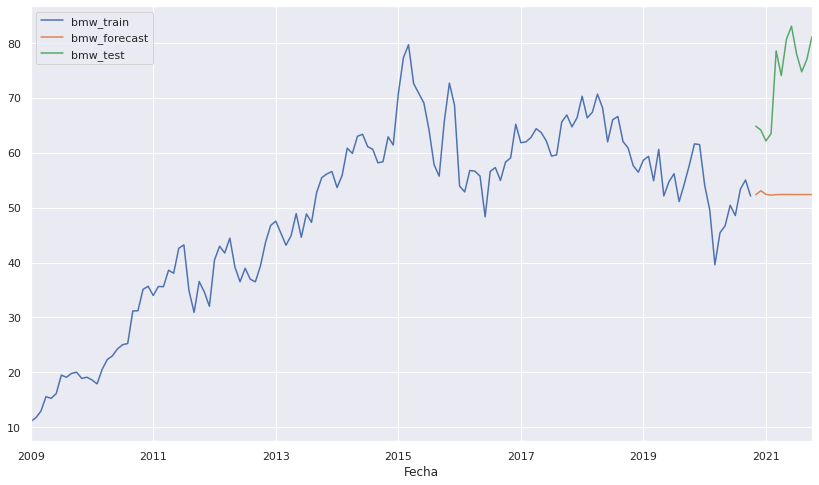

In [33]:
#Gráfico de la predicción de BMW
data_train['bmw_close'].plot(legend=True,label='bmw_train',)
data_fore['f_bmw'].plot(legend=True,label='bmw_forecast')
data_test['bmw_close'].plot(legend=True,label='bmw_test',figsize=(14,8));

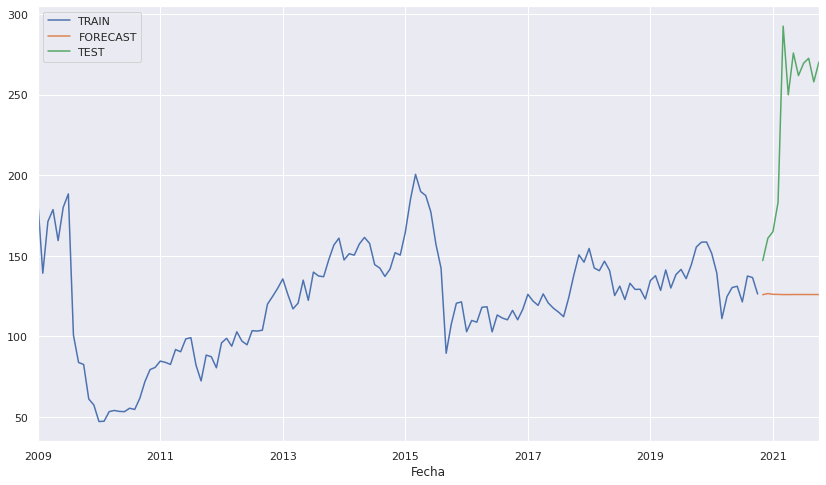

In [34]:
#Gráfico de la predicción de Volkswagen
data_train['volks_close'].plot(legend=True,label='TRAIN',)
data_fore['f_volks'].plot(legend=True,label='FORECAST')
data_test['volks_close'].plot(legend=True,label='TEST',figsize=(14,8));

Tras predecir los precios de ambas marcas para octubre de 2021, se puede ver como **ambas predicciones son muy lineales y no experimentan ningún incremento o bajada en sus precios.**

Tras comparar ambas predicciones sobre train con sus respectivos test, se puede concluir que **las predicciones no son buenas**, ya que están muy alejadas de la realidad y no muestran ningún cambio en el precio. 

Ambas predicciones están representadas con una línea recta en sus respectivos gráficos, mientras que los precios de test tienden a subir para ambas marcas.

In [35]:
#Root Mean Square Error
rmse(data_fore['f_volks'],data_test['volks_close'])

119.17367371421693

El error cuadrático medio indica el ajuste absoluto del modelo a los datos.

Como se puede ver, el **rmse del modelo es bastante alto**, por lo que los datos observados están muy alejados de los valores predichos del modelo.

## **4. Test de causalidad de Granger (Líder-seguidor)**

In [36]:
#hasta 30 retardos
gc_res = grangercausalitytests(diff_data_train[['bmw_close','volks_close']], 30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.6818  , p=0.1947  , df=1
likelihood ratio test: chi2=1.6718  , p=0.1960  , df=1
parameter F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=2.3852  , p=0.3034  , df=2
likelihood ratio test: chi2=2.3650  , p=0.3065  , df=2
parameter F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=3.0212  , p=0.3884  , df=3
likelihood ratio test: chi2=2.9886  , p=0.3934  , df=3
parameter F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8388  , p=0.5030  

El test de causalidad de Granger prueba si una variable es "útil" para
pronosticar el comportamiento de otra variable. 

Las variables/activos se pueden clasificar en líder y seguidor, siendo el líder el que cambia el precio primero, y seguidor el que lo hace después cumpliendo el pronóstico.

Tras aplicar el test sobre las variables y analizar los p-values obtenidos, se puede concluir que ninguna variable es causa de la otra, por lo que **los precios de BMW no son útiles para pronosticar los de Volkswagen y viceversa.**

## **5. ¿Es la volatilidad diaria de BMW constante? Estimar el modelo GARCH de BMW.**

### **5.1. Muestra, nuevas variables y visualización**

In [37]:
bmw_hist_close = pd.DataFrame()
bmw_hist_close['bmw_price'] = bmw_hist['Close']

In [38]:
muestra_bmw_hasta_31_10_20 = bmw_hist_close[:'2020-10-31']

In [39]:
#Log return
muestra_bmw_hasta_31_10_20['log_ret'] =np.log(muestra_bmw_hasta_31_10_20.bmw_price).diff()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#Squared Log return
#Proxy Volatility

muestra_bmw_hasta_31_10_20['Squared'] = muestra_bmw_hasta_31_10_20['log_ret']**2
muestra_bmw_hasta_31_10_20.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,bmw_price,log_ret,Squared
Fecha,,,
2020-10-26,56.098618,-0.011326,0.000128
2020-10-27,54.554375,-0.027913,0.000779
2020-10-28,51.528015,-0.057072,0.003257
2020-10-29,51.767639,0.004640,0.000022
2020-10-30,52.078259,0.005982,0.000036


Para esta segunda parte de la práctica, creo un DataFrame en el que incluyo la variable 'Close' de los datos de BMW, y cambio su nombre a 'bmw_price'. Además, selecciono los datos que me indica el enunciado, es decir, todos los disponibles hasta 31/10/2020. 

Por último, al DataFrame le añado las columnas 'log_ret' y 'Squared', que consisten en las diferencias de precio respecto al anterior en logaritmos, y esto mismo elevado al cuadrado, respectivamente.

Text(0.5, 1, 'Volatilidad')

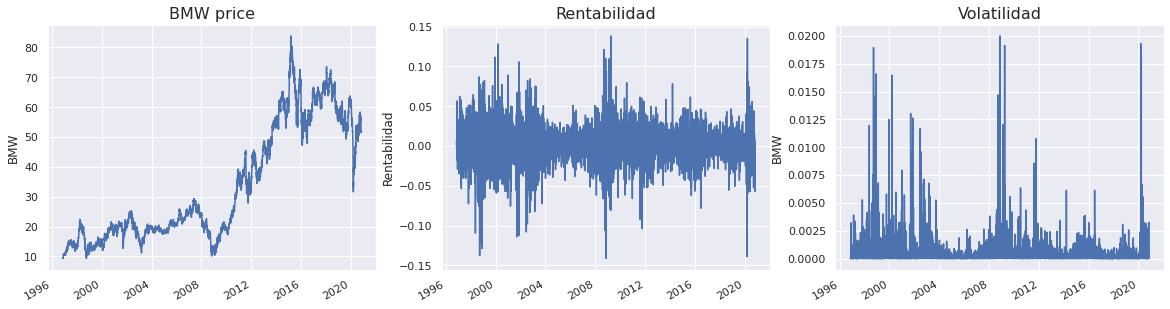

In [41]:
#Gráficos del precio, la rentabilidad y la volatilidad 

fig = plt.figure(figsize=(20,5))
plt.subplot(131)
ax = muestra_bmw_hasta_31_10_20.bmw_price.plot( linestyle ='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW price', y = 1, fontsize = 16)

plt.subplot(132)
ax = muestra_bmw_hasta_31_10_20.log_ret.plot( linestyle = '-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y = 1, fontsize = 16)

plt.subplot(133)
ax = muestra_bmw_hasta_31_10_20.Squared.plot( linestyle = '-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y = 1, fontsize = 16)

Ploteo el precio, la rentabilidad y la volatilidad para **visualizar los precios de BMW desde 1996 hasta octubre de 2020.**

Se puede apreciar como el precio ha tenido una tendencia positiva hasta 2015, y desde ahi ha ido bajando, destacando una fuerte bajada en 2020 debido al COVID.

Respecto a la rentabilidad, se encuentra entre el +-15%; y respecto a la volatilidad, los precios varían entre un 0% y un 2%, variando sobretodo en los primeros años del siglo 21, entre 2008 y 2012, y a finales de 2020.

### **5.2. Mean zero test**

In [42]:
#Test para ver si podemos rechazar que la media sea 0
alpha = 0.05
t, p = stats.ttest_1samp(muestra_bmw_hasta_31_10_20['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 1.0061951704033218
p-value: 0.31436129401223073
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


Con este test **se estudia si la media es 0 o distinta a cero**. Hay un modelo distinto dependiendo de si una media es 0 o 1.

En este caso, **no podemos rechazar la hipótesis de que la media sea 0**, ya que el p-value es superior a 5%.

In [43]:
#Create proxy Volatility 
bmw_vol = muestra_bmw_hasta_31_10_20['Squared'].astype('float64').to_period('D').sort_index().dropna()
bmw_vol.tail()

Fecha
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared, dtype: float64

### **5.3. Autocorrelation (AC) & Parcial Autocorrelation (PC)**

(<Figure size 864x576 with 3 Axes>, array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

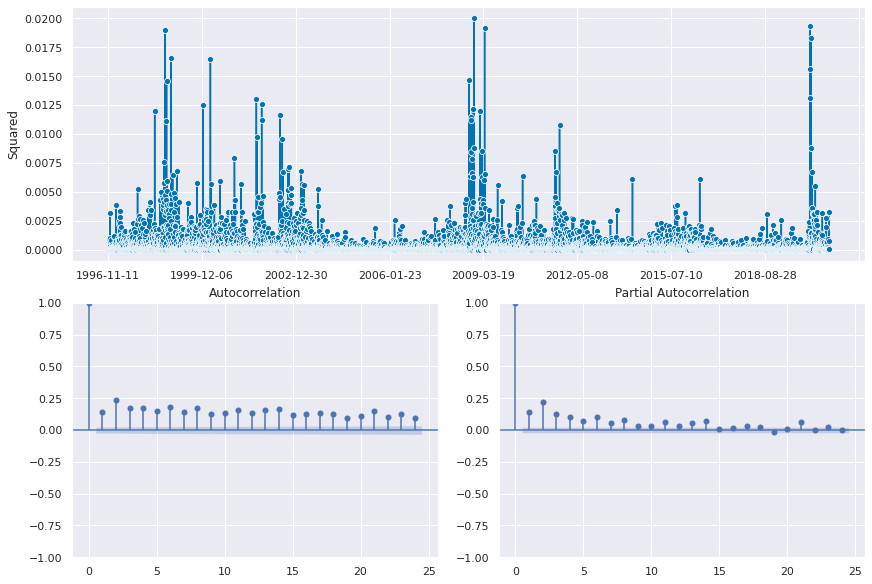

In [44]:
#Plot Autocorrelation
plot_correlations(bmw_vol)

En este caso **no es ruido blanco**, ya que los valores están fuera de la banda azul.  


### **5.4. Ljung-Box test**

In [45]:
#testing Ljung-Box
test_Ljung_Box = sm.stats.acorr_ljungbox
test_Ljung_Box(bmw_vol, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,1672.970242,0.0
20,2759.138338,0.0
30,3516.357323,0.0


Se confirma que no hay ruido blanco, ya que **pvalue < alpha**

### **5.5. Test LM-ARCH**

In [46]:
#import function test LM-Arch
test_LM_ARCH = sm.stats.diagnostic.het_arch

In [47]:
#testing LM-ARCH
#pvalue < alpha -> ARCH
lm, lmpval, f, pval, result_int =test_LM_ARCH(muestra_bmw_hasta_31_10_20['log_ret'].dropna(), nlags=20, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  774.9849972140639
p-value:  2.876945432189838e-151
Estadístico F:  44.20615519867231
p-value:  2.729220769612243e-162


In [48]:
result_int.resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     44.21
Date:                Wed, 02 Nov 2022   Prob (F-statistic):          2.73e-162
Time:                        11:03:43   Log-Likelihood:                 32839.
No. Observations:                6129   AIC:                        -6.564e+04
Df Residuals:                    6108   BIC:                        -6.550e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.93e-05      6.648      0.000    9.06e-05       0.000
x1             0.0335      0.013      2.621      0.009       0.008       0.059
x2             0.1407      0.013     10.988      0.000       0.116       0.166
x3             0.0655      0.013      5.061      0.000       0.040       0.091
x4             0.0556      0.013      4.299      0.000       0.030       0.081
x5             0.0320      0.013      2.472      0.013       0.007       0.057
x6             0.0654      0.013      5.044      0.000       0.040       0.091
x7             0.0277      0.013      2.135      0.033       0.002       0.053
x8             0.0552      0.013      4.259      0.000       0.030       0.081
x9             0.0097      0.013      0.751      0.453      -0.016       0.035
x10            0.0123      0.013      0.946      0.344      -0.013       0.038
x11            0.0444      0.013      3.422      0.001       0.019       0.070
x12            0.0170      0.013      1.312      0.190      -0.008       0.042
x13            0.0506      0.013      3.901      0.000       0.025       0.076
x14            0.0640      0.013      4.934      0.000       0.039       0.089
x15            0.0002      0.013      0.012      0.991      -0.025       0.026
x16            0.0095      0.013      0.729      0.466      -0.016       0.035
x17            0.0337      0.013      2.605      0.009       0.008       0.059
x18            0.0209      0.013      1.618      0.106      -0.004       0.046
x19           -0.0140      0.013     -1.092      0.275      -0.039       0.011
x20            0.0057      0.013      0.444      0.657      -0.019       0.031
==============================================================================
Omnibus:                     7970.907   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1798528.822
Skew:                           7.205   Prob(JB):                         0.00
Kurtosis:                      85.674   Cond. No.                         998.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **5.6. ARCH (1), donde q = 1**


In [49]:
#Modelo para la Media un AR(1)
ar = ARX(100 * muestra_bmw_hasta_31_10_20['log_ret'].dropna(), lags=[1])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:               -13509.9
Distribution:                  Normal   AIC:                           27025.8
Method:            Maximum Likelihood   BIC:                           27045.9
                                        No. Observations:                 6148
Date:                Wed, Nov 02 2022   Df Residuals:                     6146
Time:                        11:03:44   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0274  2.780e-02      0.984      0.325 

Modelo con varianza constante. 

Solo especifica el modelo de la media.

In [50]:
#MODELO ERRONEO
#ARCH(1)
ar.volatility = ARCH(p = 1)
res = ar.fit(update_freq = 0, disp = "off")
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -13345.1
Distribution:                  Normal   AIC:                           26698.2
Method:            Maximum Likelihood   BIC:                           26725.1
                                        No. Observations:                 6148
Date:                Wed, Nov 02 2022   Df Residuals:                     6146
Time:                        11:03:44   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0243  2.680e-02      0.905      0.366 

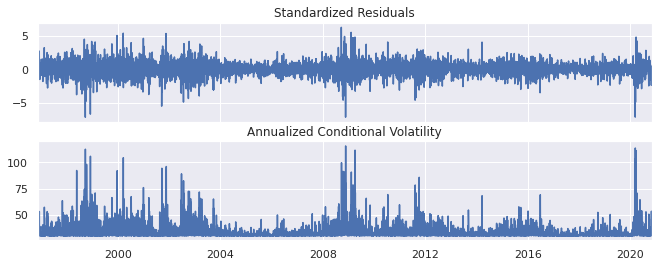

In [51]:
fig = res.plot(annualize="D")

In [52]:
#Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

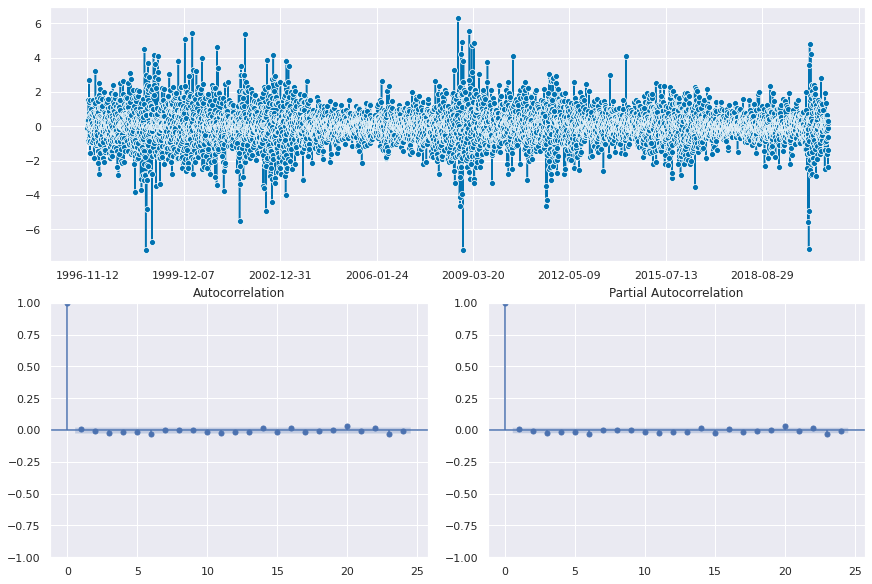

In [53]:
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

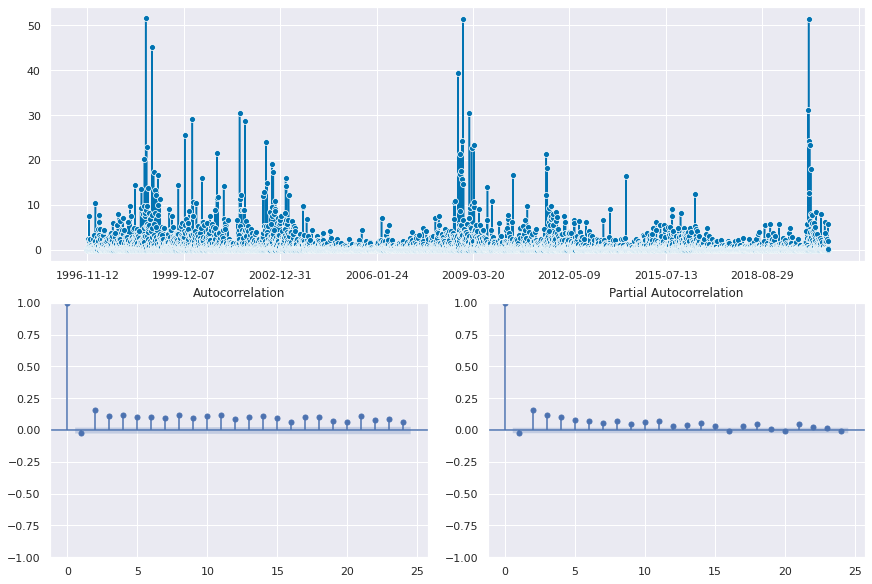

In [54]:
plot_correlations(mod1_std_resid**2)

**No es ruido blanco.**

In [55]:
#testing Ljung-Box
#pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,720.654937,2.307712e-148
20,1264.229145,1.348175e-255
30,1654.999571,0.000000e+00


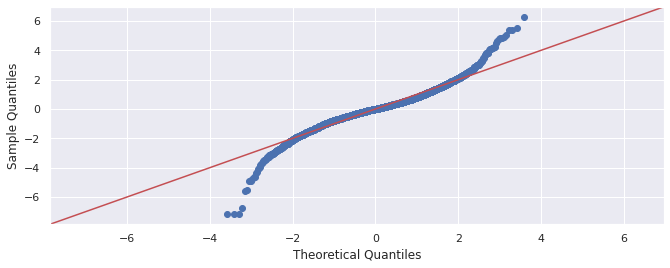

In [56]:
#qqplot
sm.qqplot(mod1_std_resid,line='45')
plt.show()

El qqplot permite observar como de cerca está la
distribución de un conjunto de datos a una distribución normal.

En el eje Y están los quantiles muestrales y en el eje X los quantiles teóricos, por lo que la idea es que los puntos se acerquen lo máximo posible a la línea roja que está en diagonal.

Se puede ver como en este caso **la muestra no sigue una distribución normal.**

### **5.7. GARCH (1,1), donde q = 1 y p = 1**

In [57]:
#GARCH (1,1)

ar = ARX(100*muestra_bmw_hasta_31_10_20['log_ret'].dropna(), lags=[1])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:               -13509.9
Distribution:                  Normal   AIC:                           27025.8
Method:            Maximum Likelihood   BIC:                           27045.9
                                        No. Observations:                 6148
Date:                Wed, Nov 02 2022   Df Residuals:                     6146
Time:                        11:03:51   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0274  2.780e-02      0.984      0.325 

In [58]:
#MODELO GARCH(1,1)
ar.volatility = GARCH(p=1,q=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12605.2
Distribution:                  Normal   AIC:                           25220.5
Method:            Maximum Likelihood   BIC:                           25254.1
                                        No. Observations:                 6148
Date:                Wed, Nov 02 2022   Df Residuals:                     6146
Time:                        11:03:51   Df Model:                            2
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const          0.0526  2.108e-02      2.496  1.258e-02 [1.

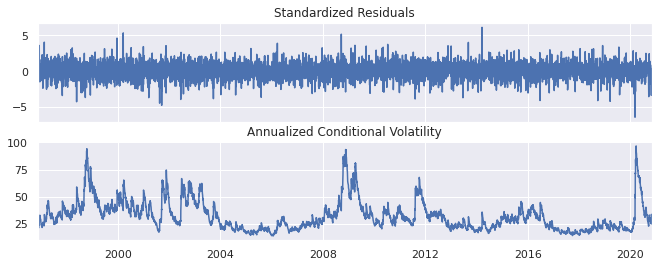

In [59]:
fig = res.plot(annualize="D")

In [60]:
#Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

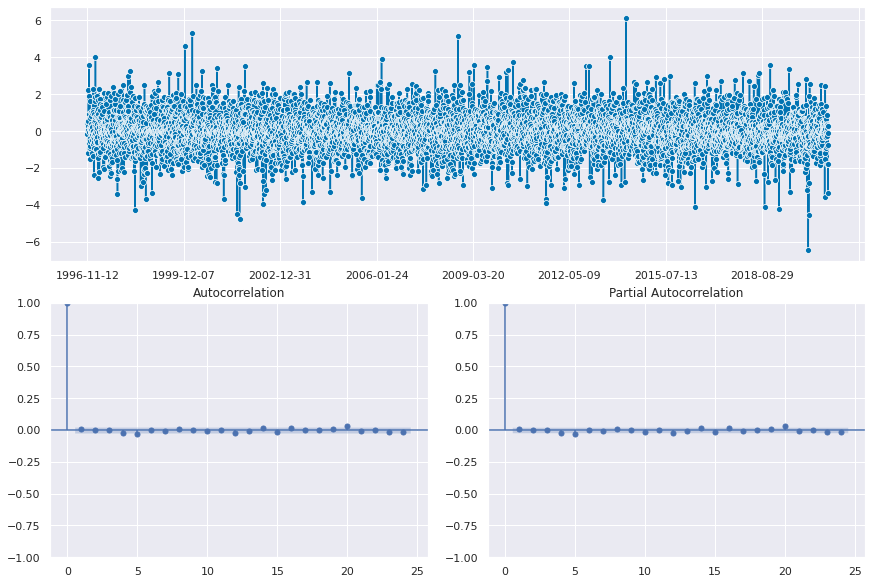

In [61]:
#Plot Autocorrelation mod1_std_resid
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

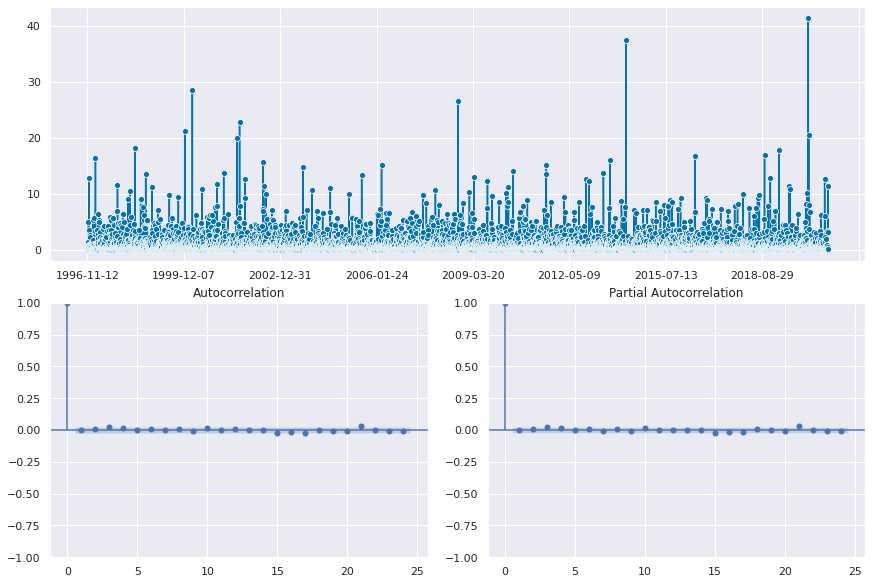

In [62]:
#Plot Autocorrelation mod1_std_resid**2
plot_correlations(mod1_std_resid**2)

**Es ruido blanco**

In [63]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,7.644415,0.663525
20,16.477177,0.686615
30,27.876041,0.577006


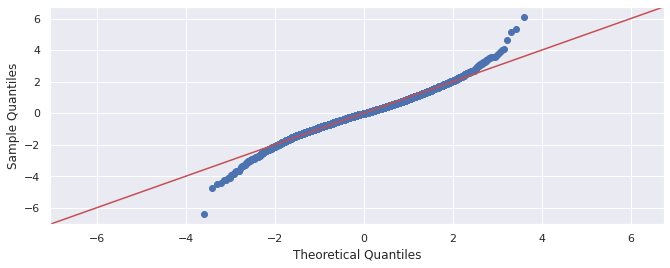

In [64]:
# qqplot
sm.qqplot(mod1_std_resid,line='45')
plt.show()

Aunque se acerca más que en el gráfico anterior, l**a muestra no sigue una distribución normal.**

### **5.8. GARCH (1,1) + T-student**

In [65]:
#GARCH (1,1) + T-student

ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12454.7
Distribution:      Standardized Student's t   AIC:                           24921.4
Method:                  Maximum Likelihood   BIC:                           24961.8
                                              No. Observations:                 6148
Date:                      Wed, Nov 02 2022   Df Residuals:                     6146
Time:                              11:03:57   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

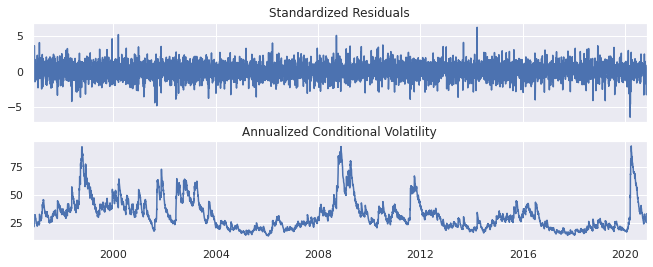

In [66]:
fig = res.plot(annualize="D")

In [67]:
#Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

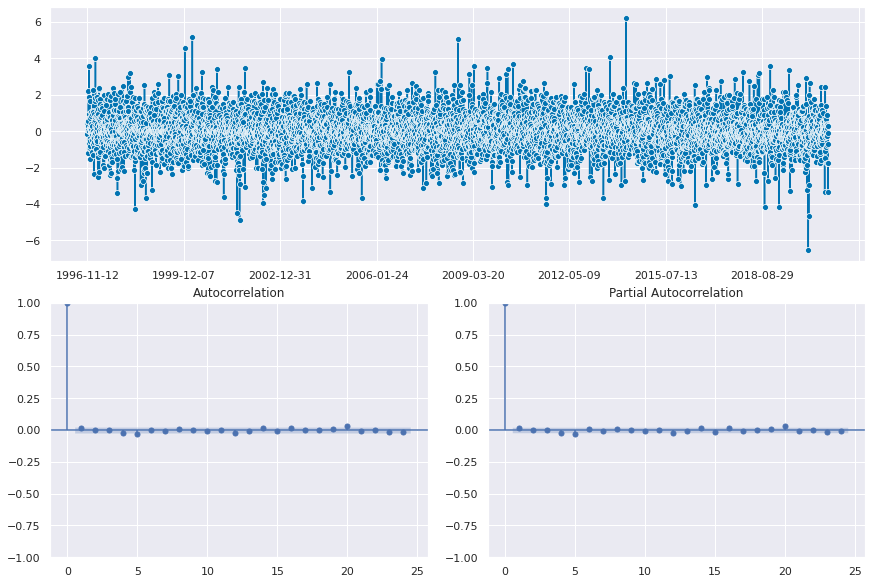

In [68]:
#Plot Autocorrelation mod1_std_resid
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

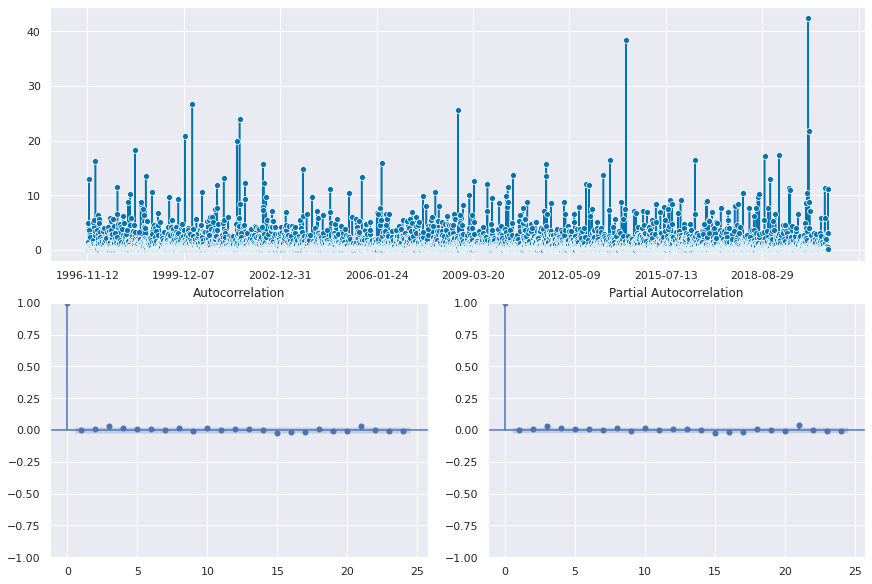

In [69]:
#Plot Autocorrelation mod1_std_resid**
plot_correlations(mod1_std_resid**2)

**Es ruido blanco**

In [70]:
#testing Ljung-Box
#pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,12.393689,0.259572
20,20.607150,0.420571
30,32.606340,0.339878


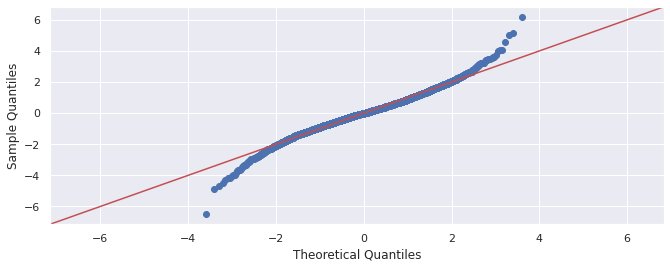

In [71]:
#qqplot normal
sm.qqplot(mod1_std_resid,line='45')
plt.show()

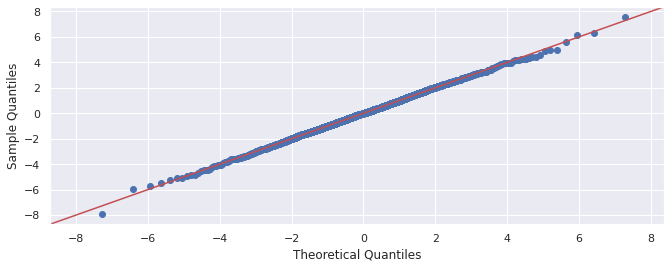

In [72]:
#qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

Como se puede ver, **cuando se aplica el modelo GARCH (1,1) + T-student, la muestra si que sigue una distribución normal**, ya que los puntos están sobre la línea en diagonal, es decir, que los quantiles teóricos y los muestrales son los mismos.

Como las autocorrelaciones de GARCH si que tienen ruido blanco, el modelo es bueno en media y constante en varianza. 

Para ver si es bueno en media, nos basamos en el GARCH (1,1), y para ver si es constante en varianza, nos basamos en el GARCH (1,1) + T-student.

**Por lo tanto, la volatilidad diaria de BMW si que es constante**

## **6. Predicción para noviembre de 2020**

In [73]:
#FORECAST VOLATILITY
forecasts = res.forecast(horizon = 30, reindex=False)

La muestra es hasta octubre de 2020, por lo que ponemos 30 dias en el horizonte para predecir la varianza diaria en el mes de noviembre.

In [74]:
#Media
pred_media = forecasts.mean
pred_media

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-10-30,0.058453,0.037142,0.0363,0.036267,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266,...,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266,0.036266


In [75]:
#Varianza
pred_varianza = (forecasts.variance**0.5)*np.sqrt(252)
pred_varianza

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-10-30,31.771656,31.837379,31.878329,31.919117,31.959783,32.000328,32.040751,32.081053,32.121236,32.161299,...,32.594269,32.632941,32.671502,32.70995,32.748287,32.786513,32.824629,32.862634,32.900531,32.938318


Tras predecir la media y la volatilidad, se puede concluir que **las predicciones son buenas ya que la volatilidad crece de una manera constante**, incrementando ligeramente cada día. Esto cuadra con el ejercicio anterior, en el que se comprobó que la volatilidad diaria de BMW es constante.